In [144]:
from typing import List, Dict, Any, Tuple, Union
from typing import Type as TypeAlias


class Learner():

    def __init__(self, schema, **kwargs):
        pass


    def _update_schema(self, new_schema):
        pass

    def set_schema(self, schema):
        pass

    def set_hyper_params(self, hyper_params: Dict[str, Any]):
        """Set hyper parameters for the learner and sub-learners.

        :param hyper_params: A dictionary of hyper parameters.
        """

    def get_hyper_params(self) -> Dict[str, Any]:
        pass



In [145]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

In [146]:

# from sklearn.naive_bayes import GaussianNB
# from sklearn.datasets import load_iris


# iris = load_iris()
# # The constructor is responsible for setting the `hyper_parameters`
# model = GaussianNB(priors="asdas")
# print(model.get_params())

# print(getattr(model, "var_", None))
# # Durring fit the schma/shape is infered from the data and the 
# # `model_state` is learnt
# model.partial_fit(iris.data, iris.target, classes=[0, 1, 2])


# # sklearn stores its `model_state` in parameters with trailing `_` by convention
# print(getattr(model, "var_", None))
# # None 
# # [[0.121764 0.140816 0.029556 0.010884]
# #  [0.261104 0.0965 0.2164 0.038324] 
# #  [0.396256 0.101924 0.298496 0.073924]]

# model.set_params


In [154]:
from abc import ABC, abstractmethod
from typing import Sequence, Optional, Union
import numpy as np
from dataclasses import dataclass


@dataclass
class Schema():
    x_shape: Sequence[int]
    y_shape: Sequence[int]
    num_classes: int        

class Instance():
    def __init__(self, x: np.ndarray, y: int, schema: Schema):
        self.x = x
        self.y = y
        self.schema = schema

class Classifier(ABC):

    @abstractmethod
    def train(self, instance: Instance) -> None:
        pass

    @abstractmethod
    def predict(self, instance: Instance) -> Union[int, None]:
        pass

    @abstractmethod
    def predict_proba(self, instance: Instance) -> Union[np.ndarray, None]:
        pass


class HyperParameters(ABC):
    @abstractmethod
    def set_hyper_params(self, **kwargs) -> None:
        pass

    @abstractmethod
    def get_hyper_params(self) -> dict:
        pass


class UnsupportedSchemaChange(RuntimeError):
    pass

class UnsupportedSchema(RuntimeError):
    pass


class CommonClassifier(Classifier):
    _is_ready: bool = False
    """Has the model state been initialized and is the data's schema known?"""
    _schema: Optional[Schema] = None
    """The schema of the data that the model has been trained on."""

    @property
    def is_ready(self) -> bool:
        return self._is_ready
    
    @property
    def schema(self) -> Optional[Schema]:
        return self._schema

    @abstractmethod
    def _predict(self, instance: Instance) -> Union[int, None]:
        """Like `predict` but the model state must be initialized."""
        pass

    @abstractmethod
    def _predict_proba(self, instance: Instance) -> Union[np.ndarray, None]:
        """Like `predict_proba` but the model state must be initialized."""
        pass

    @abstractmethod
    def _train(self, instance: Instance) -> None:
        """Like `train` but the model state must be initialized."""
        pass

    @abstractmethod
    def _initialize(self, new_schema: Schema) -> None:
        """Initialize the model state with the given schema"""
        pass

    def _on_schema_change(self, new_schema: Schema) -> None:
        """Handle the case where the schema of the data changes"""
        raise UnsupportedSchemaChange("Learner does not support schema changes")

    def predict(self, instance: Instance) -> Union[int, None]:
        if not self.is_ready:
            return None
        return self._predict(instance)
    
    def predict_proba(self, instance: Instance) -> Union[np.ndarray, None]:
        if not self.is_ready:
            return None
        return self._predict_proba(instance)
    
    def train(self, instance: Instance) -> None:
        if not self.is_ready:
            self._initialize(instance.schema)
            self._is_ready = True
            self._schema = instance.schema
        if self.schema != instance.schema:
            self._on_schema_change(instance.schema)
            self._schema = instance.schema
        self._train(instance)

In [148]:
from typing import Any
from pydantic import BaseModel

class PydanticHyperParameters(HyperParameters):
    _Config: BaseModel

    def set_hyper_params(self, **kwargs) -> None:
        params = self.get_hyper_params()
        params.update(kwargs)
        self._Config.model_validate(params)
        for attr_name, value in params.items():
            setattr(self, attr_name, value)

    def get_hyper_params(self) -> dict:
        params = {}
        for attr_name in self._Config.model_fields.keys():
            params[attr_name] = getattr(self, attr_name)
        return params
    
    def _validate_hyper_params(self) -> None:
        self._Config.model_validate(self.get_hyper_params())


In [155]:
from typing import Any, List, Literal


class KNN(CommonClassifier, PydanticHyperParameters):

    class _Config(BaseModel):
        k: int

    _data: List[Instance]

    def __init__(self, *, k: int = 3):
        self.k = k
        self._validate_hyper_params()
    
    def _initialize(self, new_schema: Schema) -> None:
        self._data = []

    def _on_schema_change(self, new_schema: Schema) -> None:
        self._data = []

    def _train(self, instance: Instance) -> None:
        self._data.append(instance)
    
    def _predict_proba(self, instance: Instance) -> Union[np.ndarray, None]:
        distances = np.array([np.linalg.norm(instance.x - data.x) for data in self._data])
        sorted_indices = np.argsort(distances)
        k_indices = sorted_indices[:self.k]
        k_labels = [self._data[i].y for i in k_indices]
        return np.bincount(k_labels, minlength=self.schema.num_classes) / self.k
    
    def _predict(self, instance: Instance) -> Union[int, None]:
        return np.argmax(self._predict_proba(instance))


In [156]:
class KNN(CommonClassifier, HyperParameters):

    def __init__(self, *, k: int = 3):
        self.k = k
    
    def _initialize(self, new_schema: Schema) -> None:
        self._data = []

    def _on_schema_change(self, new_schema: Schema) -> None:
        self._data = []

    def _train(self, instance: Instance) -> None:
        self._data.append(instance)
    
    def _predict_proba(self, instance: Instance) -> Union[np.ndarray, None]:
        distances = np.array([np.linalg.norm(instance.x - data.x) for data in self._data])
        sorted_indices = np.argsort(distances)
        k_indices = sorted_indices[:self.k]
        k_labels = [self._data[i].y for i in k_indices]
        return np.bincount(k_labels, minlength=self.schema.num_classes) / self.k
    
    def _predict(self, instance: Instance) -> Union[int, None]:
        return np.argmax(self._predict_proba(instance))
    
    def set_hyper_params(self, **kwargs) -> None:
        for attr_name, value in kwargs.items():
            setattr(self, attr_name, value)

    def get_hyper_params(self) -> dict:
        return {"k": self.k}
    


In [158]:
from sklearn.datasets import load_iris

iris = load_iris()
schema = Schema(x_shape=[4], y_shape=[3], num_classes=3)
instances = [Instance(x, y, schema) for x, y in zip(iris.data, iris.target)]

knn = KNN(k=10)
# knn.k = "hello"

for instance in instances:
    knn.train(instance)

print(knn.predict_proba(instances[1]), instances[1].y)

[1. 0. 0.] 0


In [151]:
KNN._Config.model_fields.keys()

dict_keys(['k'])

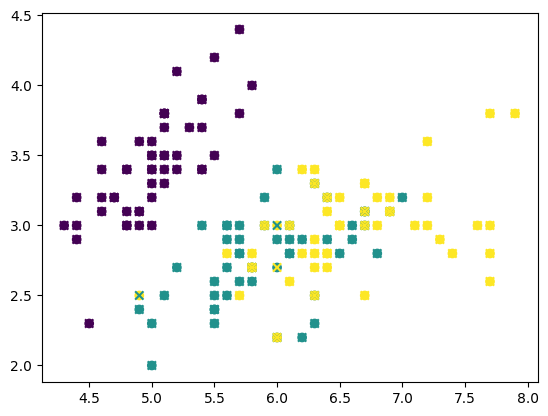

In [159]:
from matplotlib import pyplot as plt

x = iris.data
y = iris.target
plt.scatter(x[:, 0], x[:, 1], c=y)

y_hat = [knn.predict_proba(Instance(x, 0, schema)) for x in x]
y_hat = np.array(y_hat)

plt.scatter(x[:, 0], x[:, 1], c=np.argmax(y_hat, axis=1), marker='x')



In [ ]:
from pydantic import BaseModel


class Base():
    _internal: int = 0


class Derived(Base, BaseModel):
    configurable: int = 0


derived = Derived()
derived.configurable = "sasd"
derived

Derived(configurable='sasd')